# Influence of COSMO-CLM grid resolution on simulated precipitation

In [1]:
from netCDF4 import Dataset
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
import numpy as np
import seaborn as sns
import datetime as dt
import cartopy.crs as ccrs
import cartopy.feature as cf

# plot settings
sns.set_theme(style="darkgrid", context="notebook")
%config InlineBackend.figure_format = "retina"
plt.rcParams["figure.dpi"] = 300
plt.rcParams["savefig.bbox"] = "tight"

# map projection
# map projection
# grid_mapping = rotated_pole
# grid_mapping_name = rotated_latitude_longitude
# long_name = "coordinates of the rotated North Pole"
# grid_north_pole_latitude = 35.f
# grid_north_pole_longitude = -168.f
proj = ccrs.RotatedPole(pole_latitude=35, pole_longitude=-168)
trans = ccrs.PlateCarree()

# parameters
res = ["02", "05", "1"]

### General remarks

- ICON hat nur passende boundary files für Gitterstruktur `europa00625` (und damit nur die entsprechende Auflösung möglich) -> deshalb COSMO
- Die Simulationen wurden für drei verschiedene Gitterauflösungen (0,2°, 0,5°, 1°) durchgeführt, jeweils über Europa und mit zehn Bodenlevels bis zu einer Bodentiefe von 11,5m
- Die Anfangs- & Randbedingungen wurden aus ERA-Interim (weil neuer als ERA-40) gebastelt, diese Reanalyse hat eine Auflösung von 0,75° (~83km)
- Die Ränder (mit Artefakten durch Interpolation) können nur mit `sellonlatbox` abgeschnitten werden, da die Gitter mit den verschiedenen Auflösungen nicht exakt die gleiche Region abdecken
- Mittelwert statt Summe verwenden, da die Gesamtanzahl der Gitterboxen für jede Simulation unterschiedlich ist
- $\frac{\mathrm{kg}}{\mathrm{m^2}}$ entspricht einer Regenhöhe von $1\mathrm{mm}$, daher kann die tägliche Niederschlagsmenge ganz einfach in $\frac{\mathrm{mm}}{\mathrm{day}}$ umgerechnet werden (Faktor 1)

### COSMO Variablen
- `011  0  tot_prec 0.0 1.0 total precipitation amount  [kg m-2] False undef undef`

### Reference data
- ERA5 reanalysis data (originally 1hr output, 0.28° resolution)
- units = "m"

### Spatial domain

Mean of daily precipitation sum during simulation period

In [2]:
# import rotated coordinates from cropped data to draw rectangles
rlon = {}
rlat = {}

for r in res:
    f = Dataset(f"../output/totprec_{r}deg_timmean.nc")
    rlon[r] = f.variables["rlon"][:]
    rlat[r] = f.variables["rlat"][:]
    f.close()

In [3]:
# import data
lon = {}
lat = {}
totprec = {}

for r in res:
    f = Dataset(f"../output/totprec_{r}deg_nocrop_timmean.nc")
    lon[r] = f.variables["lon"][:]
    lat[r] = f.variables["lat"][:]
    totprec[r] = f.variables["tot_prec"][0,:,:]
    f.close()

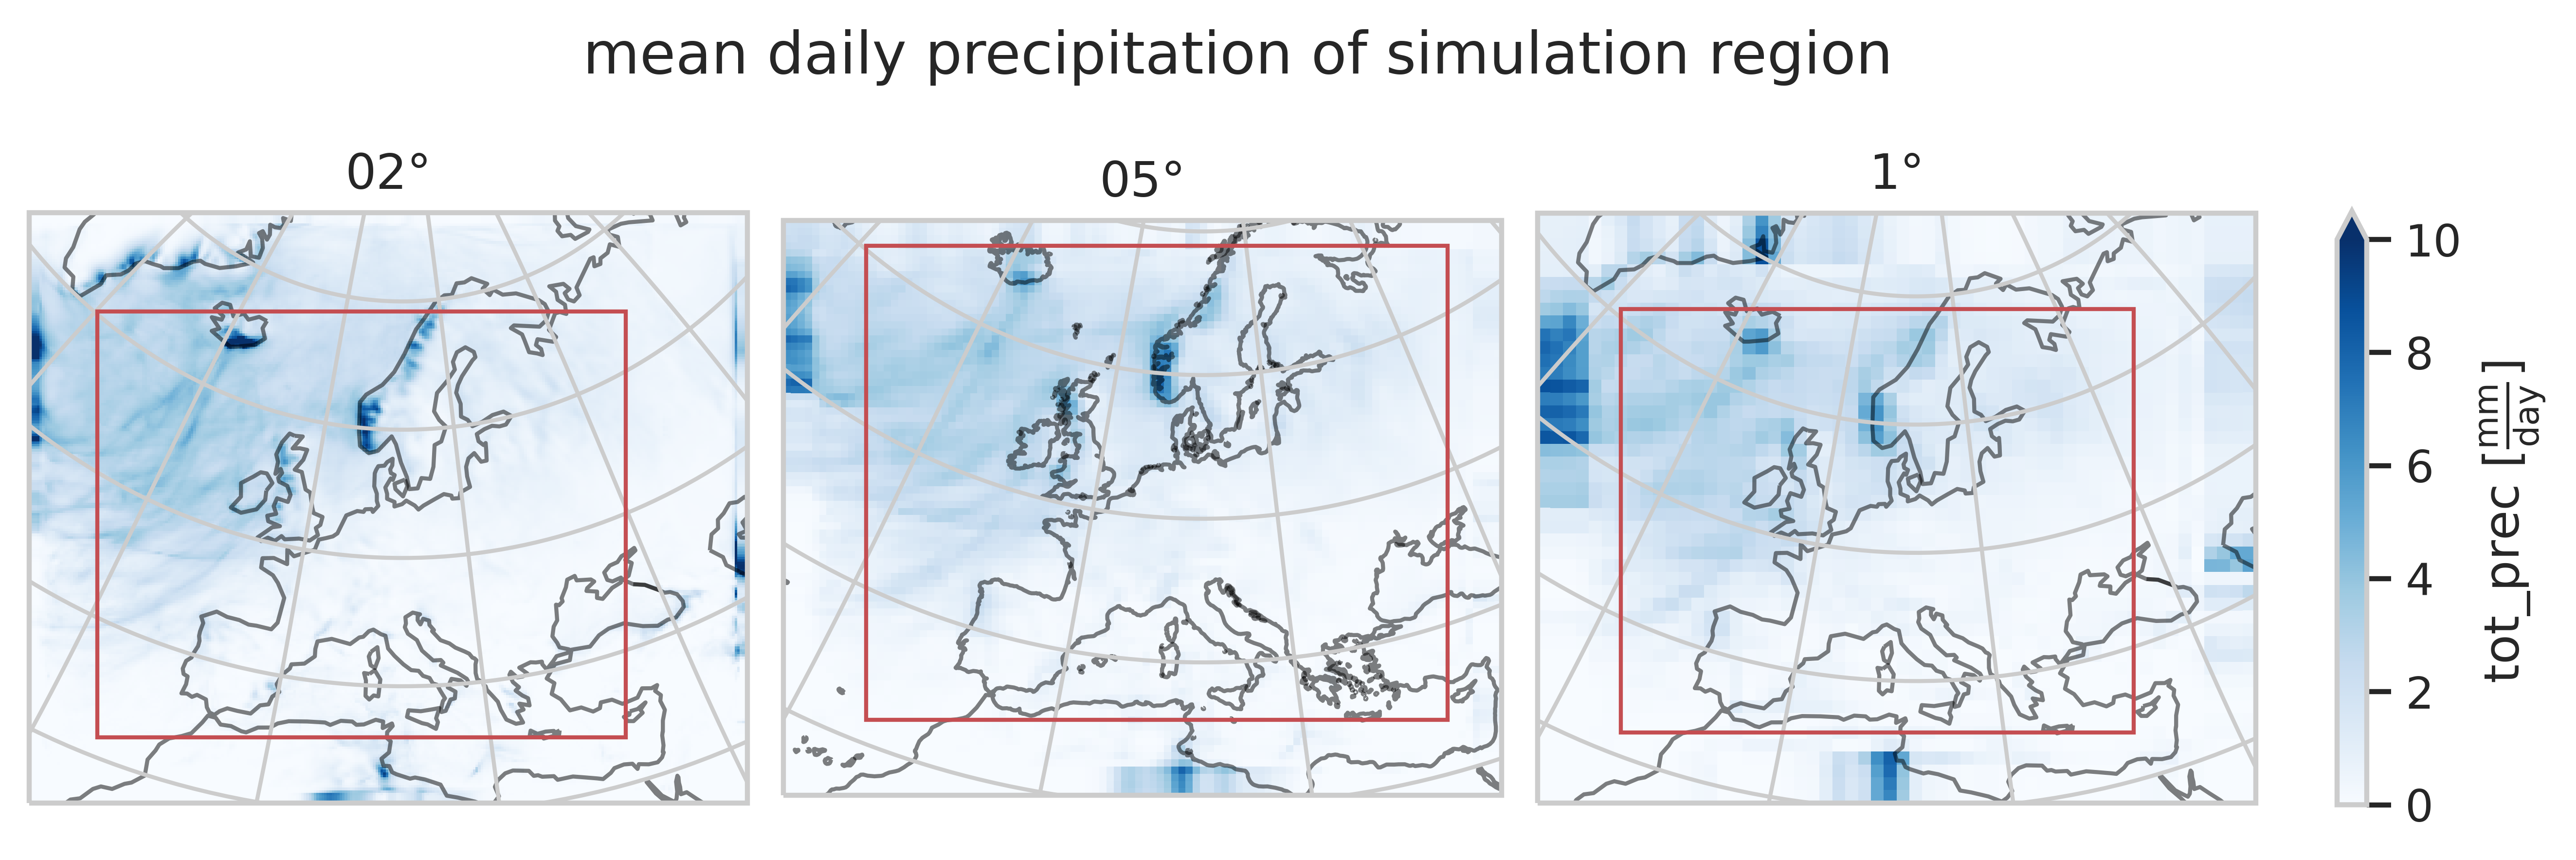

In [4]:
# plotting
with sns.axes_style("whitegrid"):
    fig, axs = plt.subplots(1, 3, figsize=(12,8), gridspec_kw=dict(wspace=0.05), subplot_kw=dict(projection = proj))

    for i, r in enumerate(res):
        cm = axs[i].pcolormesh(lon[r], lat[r], totprec[r], transform=trans, shading="nearest", cmap="Blues", vmin=0, vmax=10)
        axs[i].coastlines(alpha=0.5)
        axs[i].gridlines()
        axs[i].set_title(f"{r}°")
        # plot rectangle
        lon_corners = np.array([rlon[r][0], rlon[r][-1], rlon[r][-1], rlon[r][0]])
        lat_corners = np.array([rlat[r][-1], rlat[r][-1], rlat[r][0], rlat[r][0]])
        poly_corners = np.zeros((len(lon_corners), 2))
        poly_corners[:,0] = lon_corners
        poly_corners[:,1] = lat_corners
        poly = mpatches.Polygon(poly_corners, closed=True, fill=False, lw=1, transform=proj, ec="r", zorder=10)
        #rec = mpatches.Rectangle(xy=[rlon[r][0], rlat[r][-1]], width=len(rlon[r]), height=len(rlat[r]),
        #                         transform=proj)
        axs[i].add_patch(poly)
        
    
    cb = fig.colorbar(cm, extend="max", shrink=0.33, pad=0.03, ax=axs.tolist())
    cb.set_label(r"tot_prec [$\frac{\mathrm{mm}}{\mathrm{day}}$]")    
    fig.suptitle("mean daily precipitation of simulation region", x=0.47, y=0.7)
    fig.savefig("../report/figs/1-regionbox.png")

- Das Zielgebiet der 0,5°-Simulation weicht vom Rest ab, warum? -> im `LMGRID.txt` sind zu wenige Gitterpunkte angegeben
- "Falsche" Werte an den Rändern
- Außerdem ist beim Mittelwert zu beachten:
`cdo fldmean (Warning): Grid cell bounds not available, using constant grid cell area weights!`

***

- Daher wird die simulierte Region an den Rändern abgeschnitten (`sellonlatbox,-17,33,36,67`)

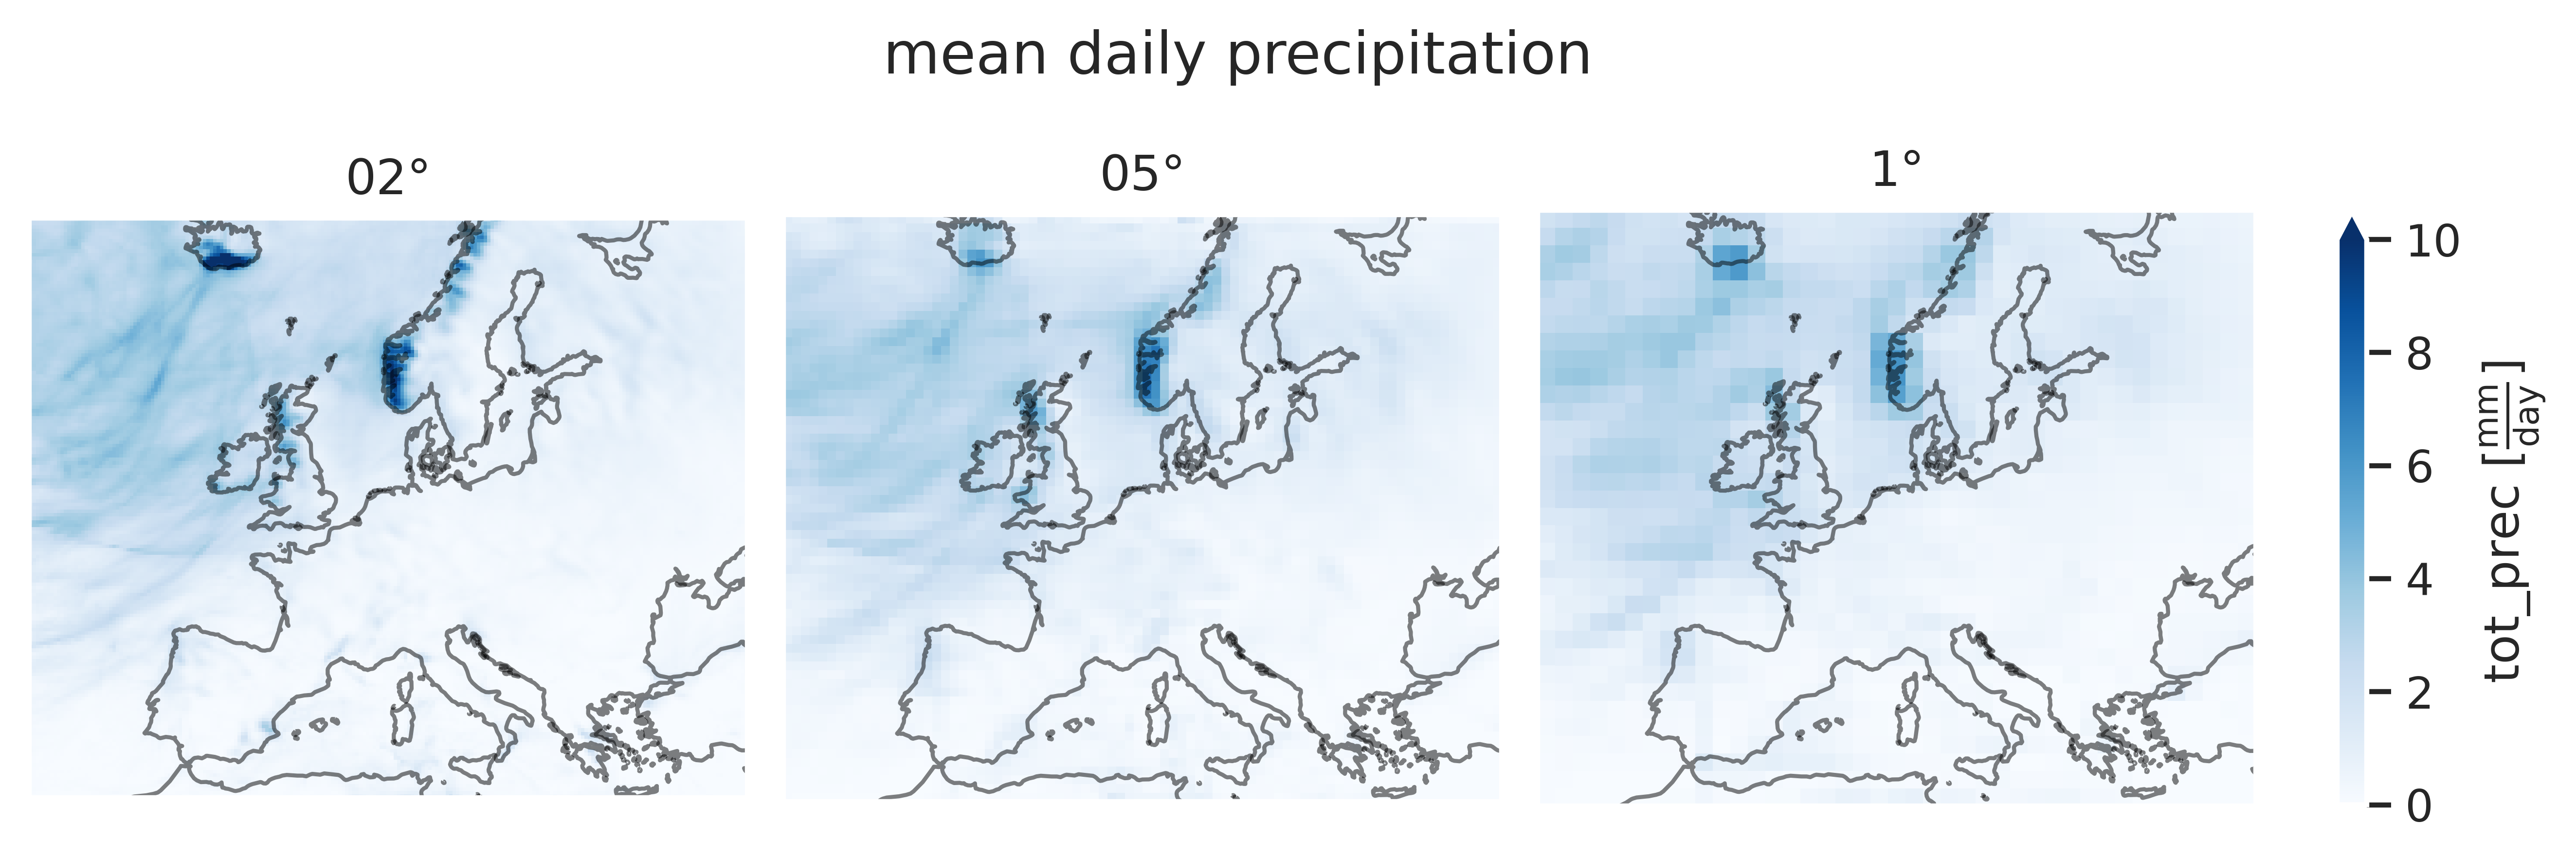

In [5]:
# import data
lon = {}
lat = {}
totprec = {}

for r in res:
    f = Dataset(f"../output/totprec_{r}deg_timmean.nc")
    lon[r] = f.variables["lon"][:]
    lat[r] = f.variables["lat"][:]
    totprec[r] = f.variables["tot_prec"][0,:,:]
    f.close()

# plotting
fig, axs = plt.subplots(1, 3, figsize=(12,8), gridspec_kw=dict(wspace=0.05), subplot_kw=dict(projection = proj))

for i, r in enumerate(res):
    cm = axs[i].pcolormesh(lon[r], lat[r], totprec[r], transform=trans, shading="nearest", cmap="Blues", vmin=0, vmax=10)
    axs[i].coastlines(alpha=0.5)
    #axs[i].gridlines(draw_labels=True)
    axs[i].set_title(f"{r}°")
    
cb = fig.colorbar(cm, extend="max", shrink=0.33, pad=0.03, ax=axs.tolist())
cb.set_label(r"tot_prec [$\frac{\mathrm{mm}}{\mathrm{day}}$]")    
fig.suptitle("mean daily precipitation", x=0.47, y=0.7)
fig.savefig("../report/figs/2-timmean.png")

- Mehr Niederschlag bei höherer Auflösung, aber räumliche Strukturen ähnlich (vorallem über Atlantik)

### Temporal domain

Mean of daily precipitation sum within "adjusted" region

In [6]:
# RefTime =  1990-01-01 00:00:00  Units = seconds  Calendar = proleptic_gregorian
# however, the output data of the simulations is always at 0000 timestep,
# which actually refers to the precipitation sum of the previous day, hence,
# using 1989-12-31 as reference date
def convTime(tlist):
    tt = []
    for t in tlist:
        tt.append(dt.date(1989, 12, 31) + dt.timedelta(seconds=t))
    return tt

# import data
totprec = {}

for r in res:
    f = Dataset(f"../output/totprec_{r}deg_fldmean.nc")
    time = convTime(f.variables["time"][1:]) # cut first value 
    totprec[r] = f.variables["tot_prec"][1:,0,0]
    f.close()

In [7]:
# RefTime =  1989-12-01 06:00:00  Units = hours  Calendar = proleptic_gregorian
def convTime_rea(tlist):
    tt = []
    for t in tlist:
        date_era = (dt.datetime(1989, 12, 1, hour=6) + dt.timedelta(hours=t)).date()
        tt.append(date_era)
    return tt
    
# import reanalysis date
f = Dataset(f"../output/era5_nocftp_fldmean.nc")
time_rea = convTime_rea(f.variables["time"][:-2]) # cut last value
tp_rea = f.variables["nocftp"][:-2,0,0] * 1000 # convert from m to mm
f.close()

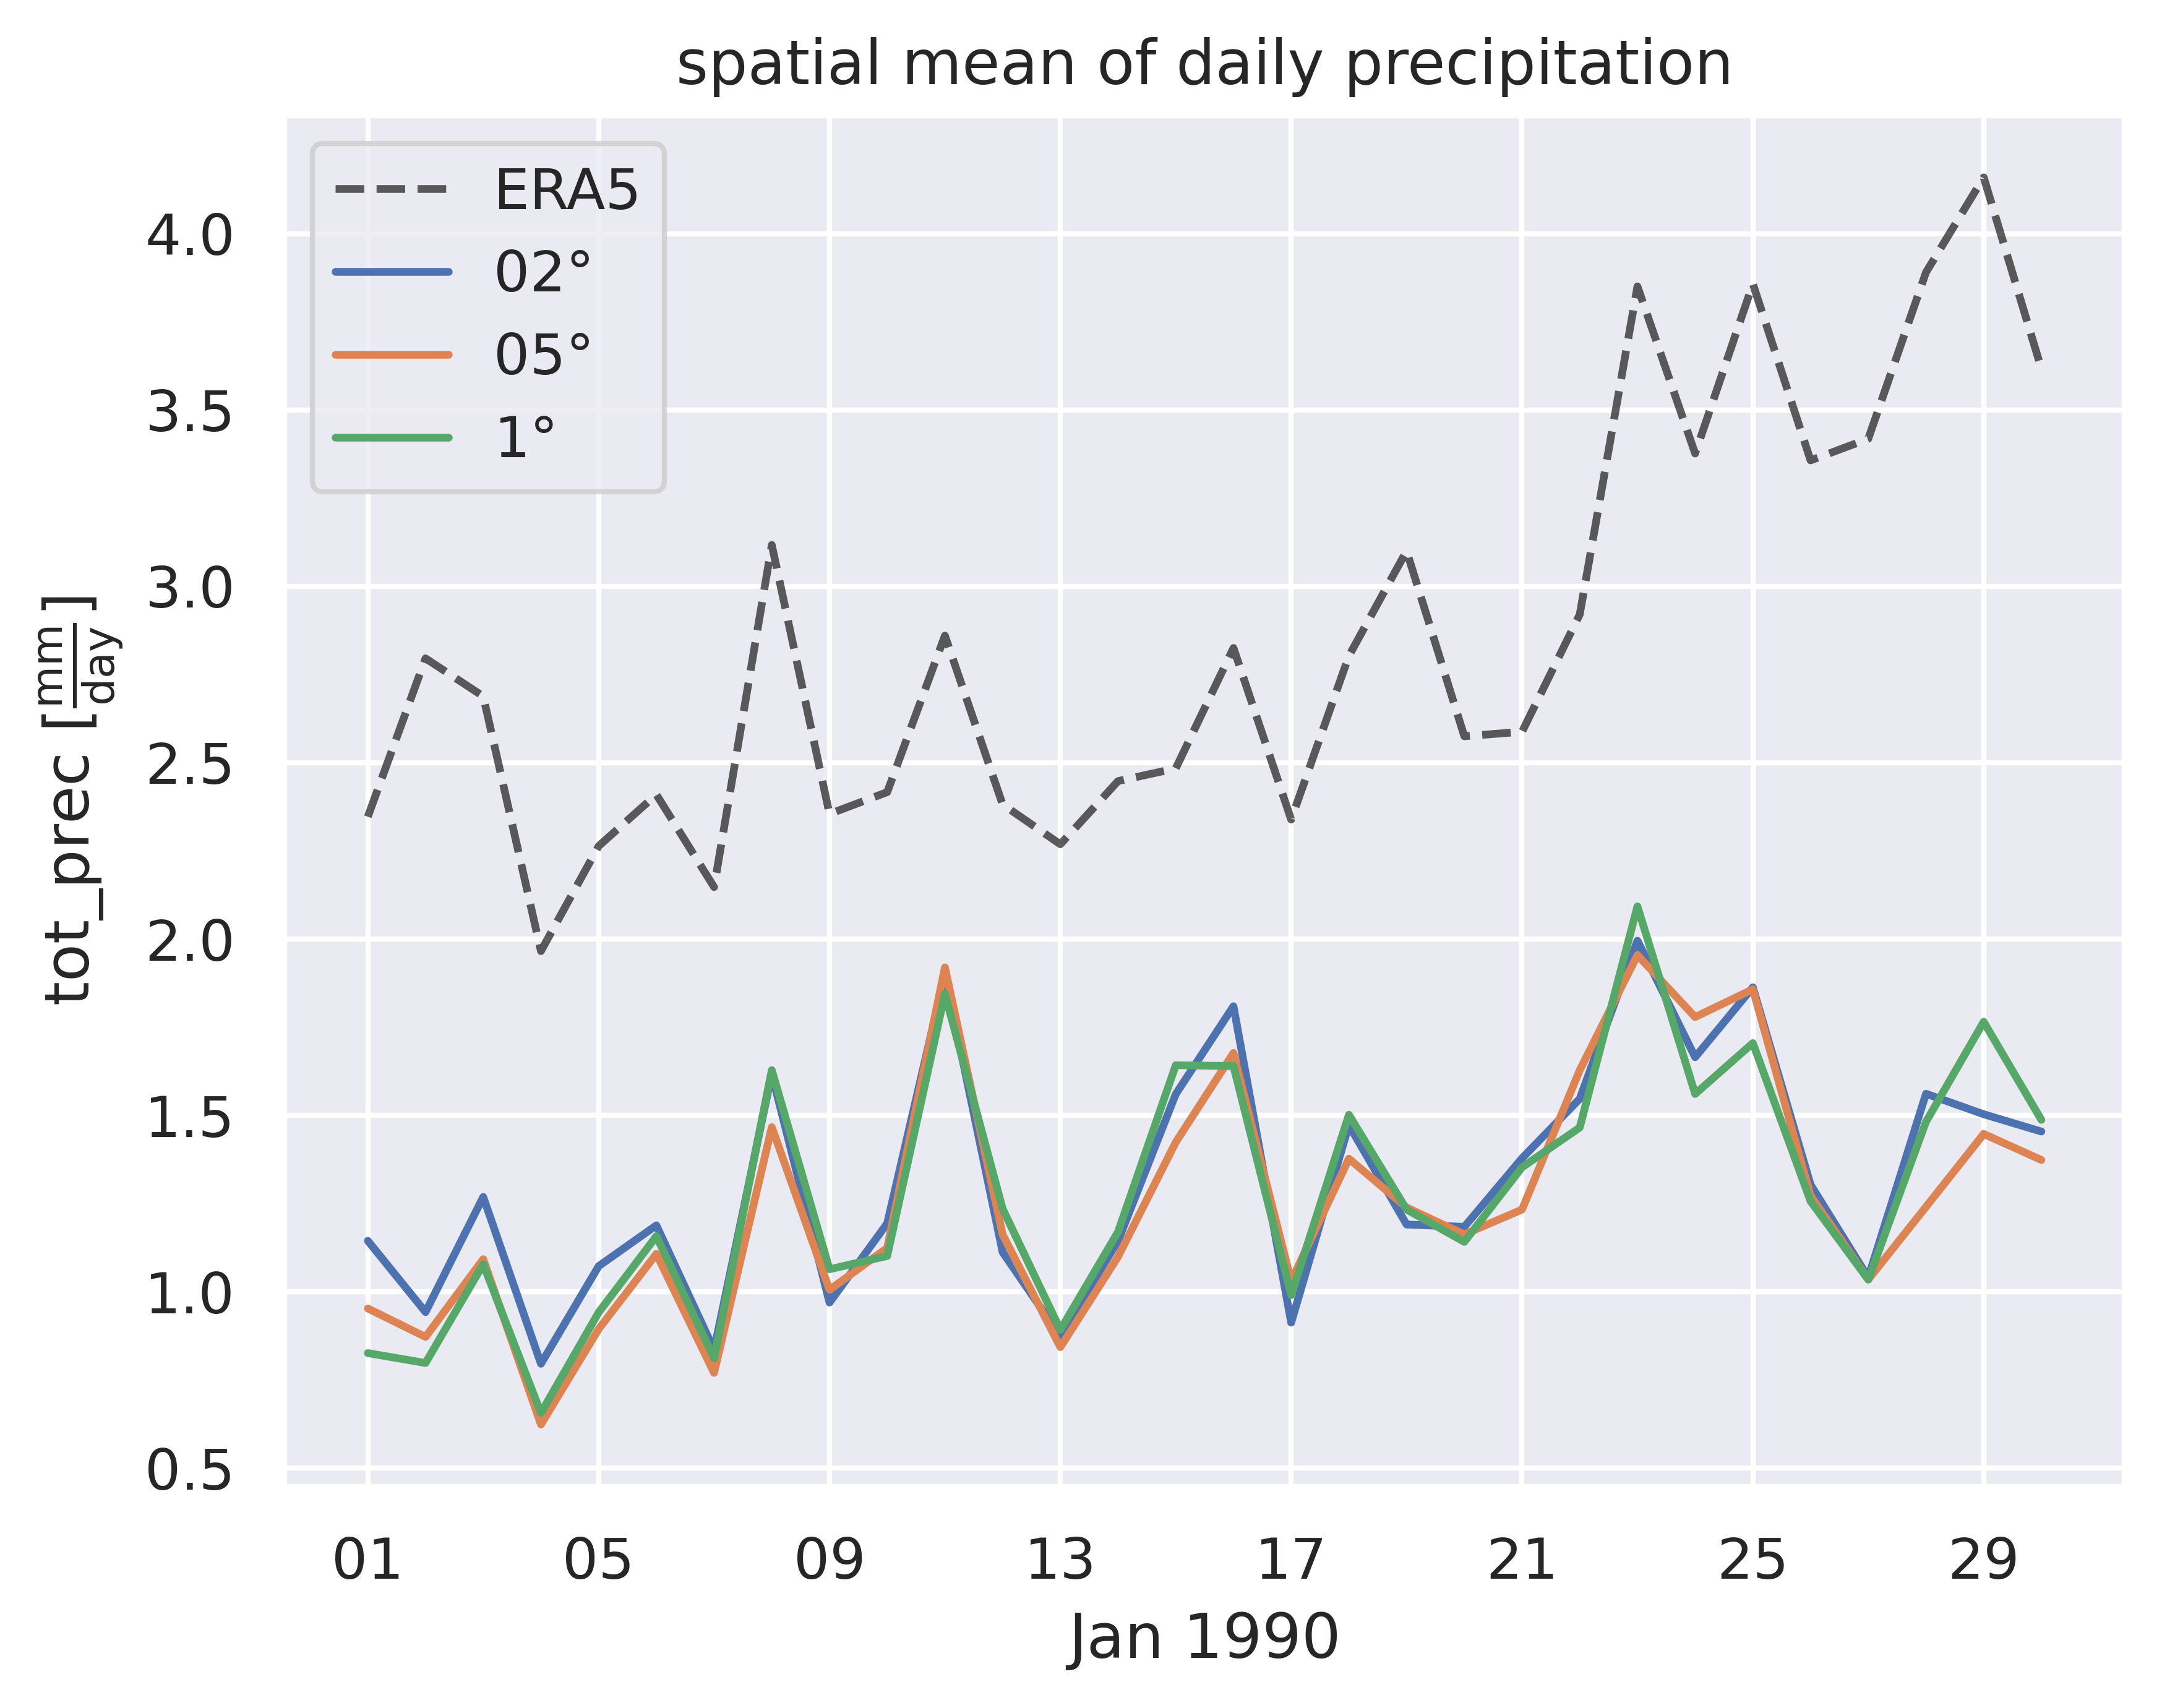

In [8]:
# plotting
fig, ax = plt.subplots()

ax.plot(time_rea, tp_rea, label="ERA5", c="k", ls="--", alpha=0.7)

for r in res:
    ax.plot(time, totprec[r], label=f"{r}°")
    
ax.legend()
ax.set_title("spatial mean of daily precipitation")
ax.set_ylabel(r"tot_prec [$\frac{\mathrm{mm}}{\mathrm{day}}$]")
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d"))
ax.set_xlabel("Jan 1990")
fig.savefig("../report/figs/3-fldmean.png")

- lieber als bar plot?
- Trend zwischen Auflösungen gleich, aber absolute Werte unterschiedlich
- Erster Tag ist zum Start der Simulation, also noch kein Niederschlag
- Picke Tage mit viel Niederschlag heraus
- Außerdem Zunahme des Gesamtniederschlags mit Simulationsdauer
- ERA5 ist wohl unterschiedlich zu ERA-int & daher könnte der Niederschlag so unterschiedlich sein

### Hovmöller diagram

In [9]:
# import data
rlon = {}
totprec_meri = {}

for r in res:
    f = Dataset(f"../output/totprec_{r}deg.nc")
    time = convTime(f.variables["time"][1:]) # cut first value
    rlon[r] = f.variables["rlon"][:]
    # calculate meridional mean (in rotated coordinates)
    totprec_meri[r] = np.mean(f.variables["tot_prec"][1:,:], axis=1)
    f.close()
    
# reanalysis data
f = Dataset(f"../output/era5_nocftp.nc")
time_rea = convTime_rea(f.variables["time"][:-2]) # cut last value
rlon_rea = f.variables["rlon"][:]
# calculate meridional mean (in rotated coordinates)
tp_rea_meri = np.mean(f.variables["nocftp"][:-2,:] * 1000, # convert from m to mm
                         axis=1)
f.close()

In [10]:
np.shape(totprec_meri[res[0]])

(30, 207)

In [11]:
np.shape(rlon[res[0]])

(207,)

In [12]:
np.shape(time)

(30,)

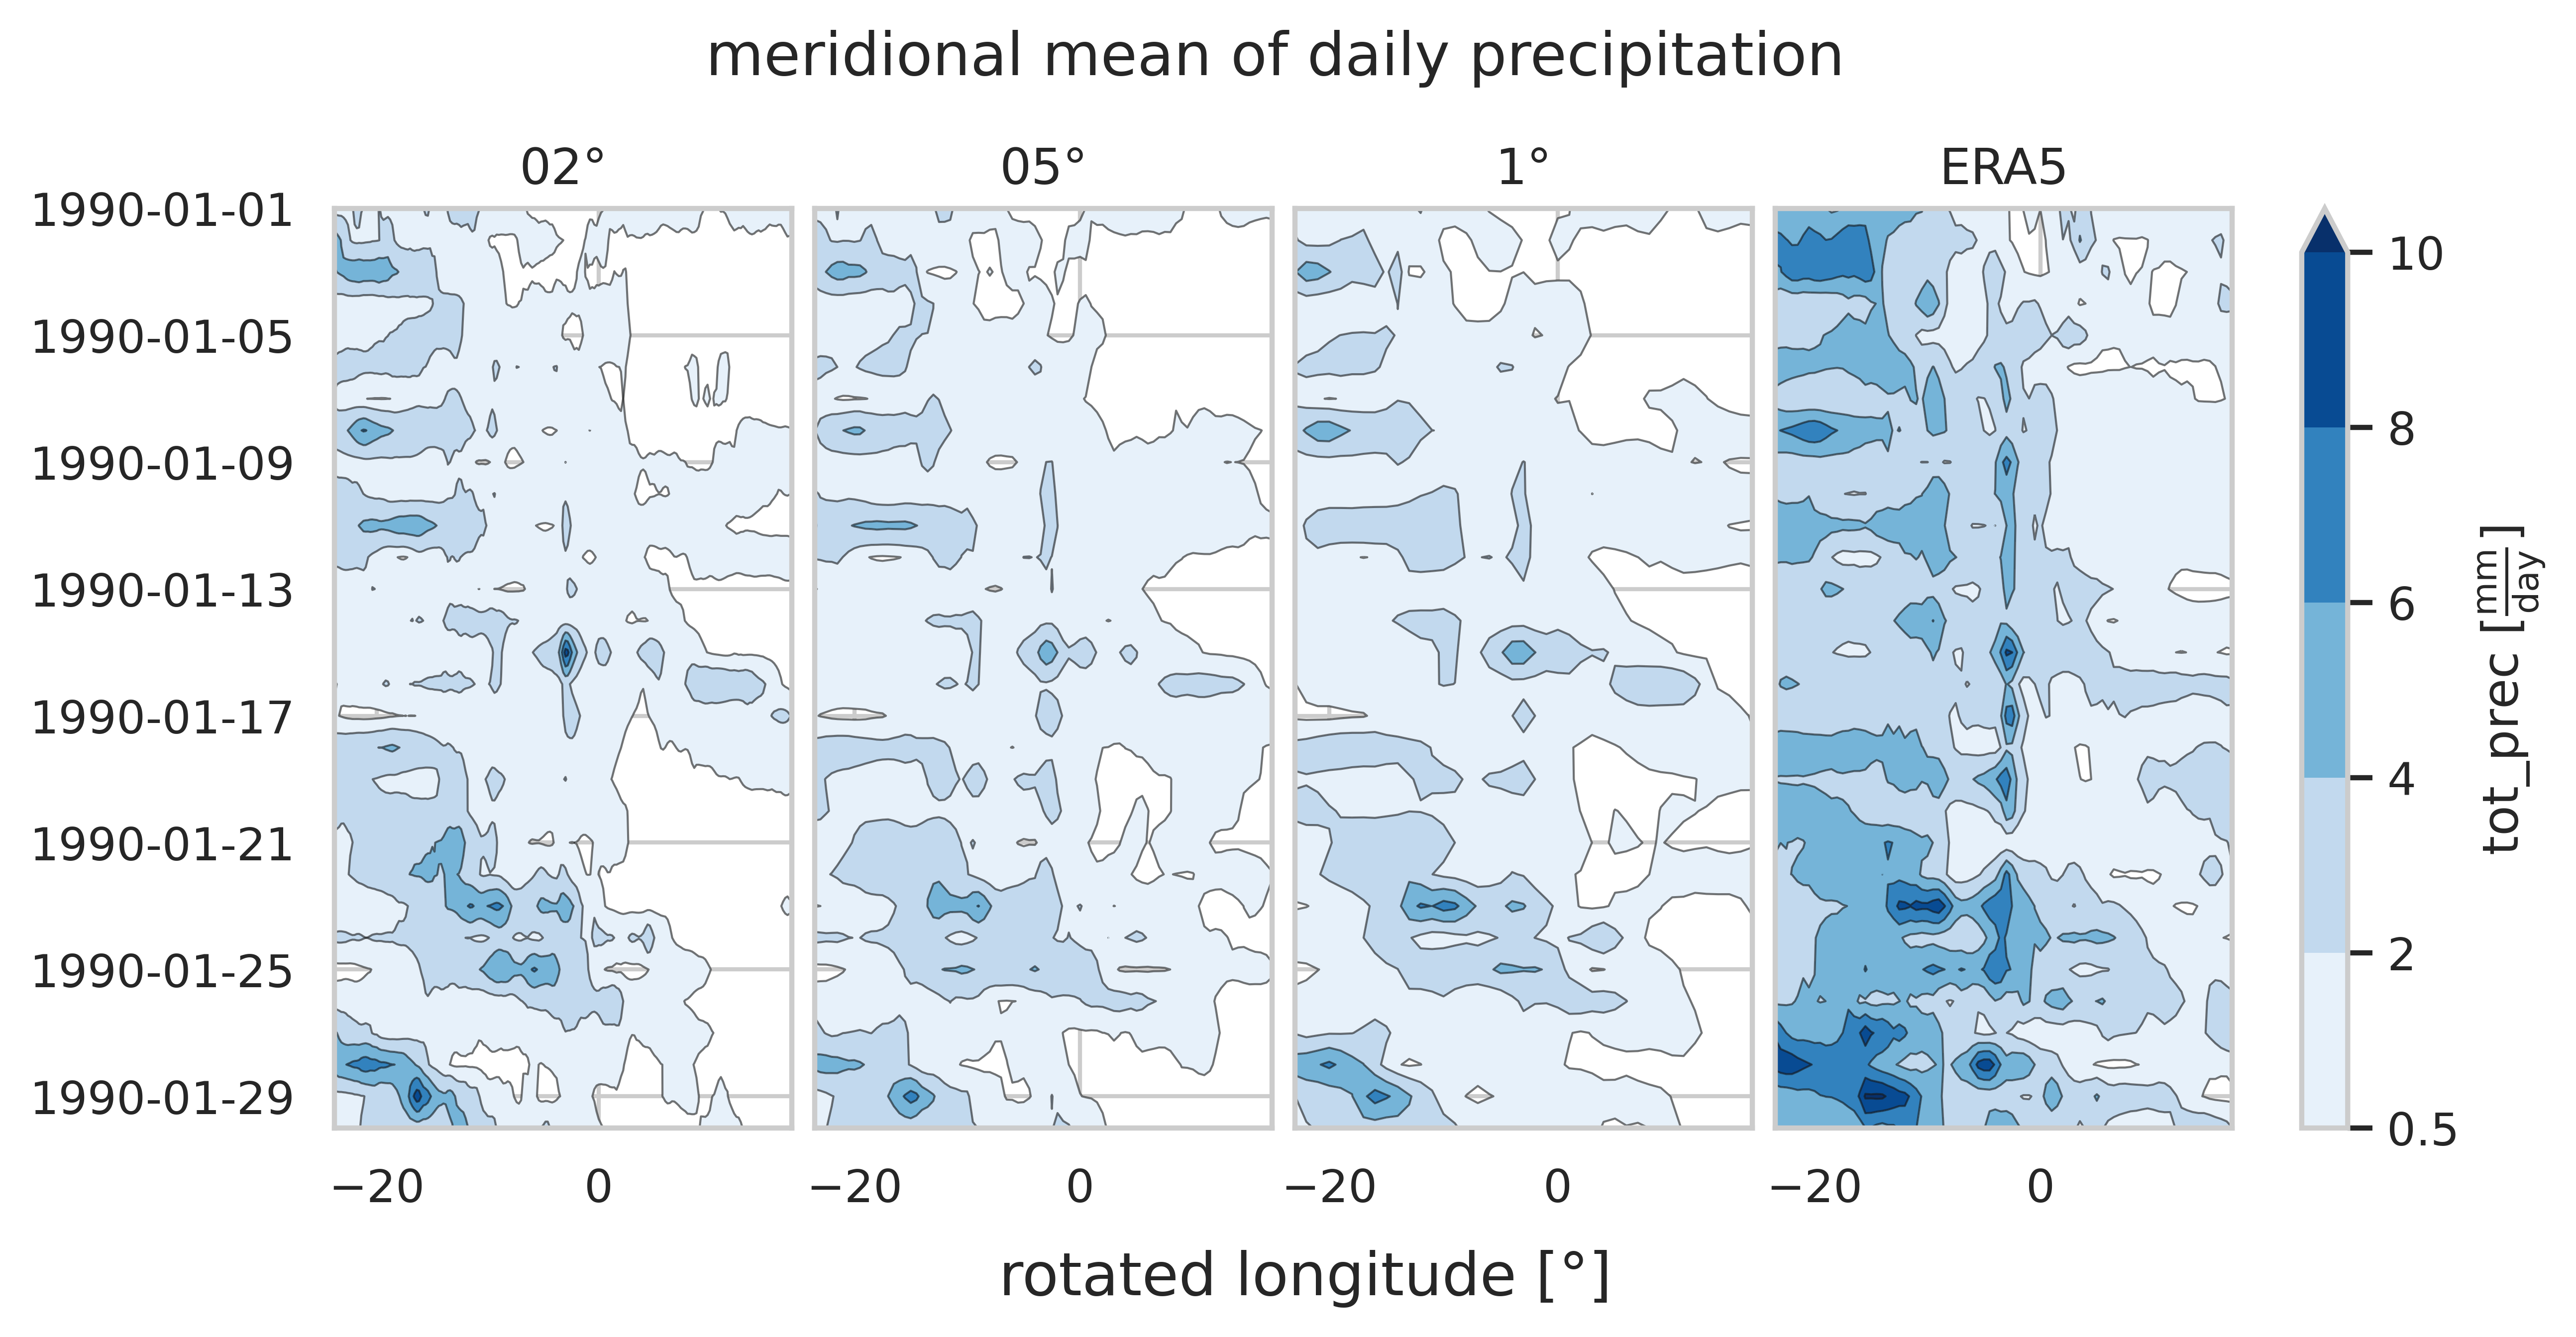

In [13]:
# tick locations and labels of colorbar
cticks = [0.5, 2, 4, 6, 8, 10]
clabels = ["0.5", "2", "4", "6", "8", "10"]

# plotting (temporarily change the rc parameter values)
with sns.axes_style("whitegrid"):
    fig, axs = plt.subplots(1, 4, figsize=(10,4), sharey=True, gridspec_kw=dict(wspace=0.05))

    for i, r in enumerate(res + ["rea"]):
        
        if r == "rea":
            xrlon, ytime = np.meshgrid(rlon_rea, time_rea)
            cf = axs[i].contourf(xrlon, ytime, tp_rea_meri, cmap="Blues", levels=cticks, extend="max")
            axs[i].contour(cf, colors="k", linewidths=0.5, alpha=0.6)
            axs[i].set_title("ERA5")
            axs[i].invert_yaxis()
            #axs[i].set_ylim(top=dt.date(1990, 1, 1)) # cutting first value is equivalent
        
        else:
            xrlon, ytime = np.meshgrid(rlon[r], time)
            cf = axs[i].contourf(xrlon, ytime, totprec_meri[r], cmap="Blues", levels=cticks, extend="max")
            axs[i].contour(cf, colors="k", linewidths=0.5, alpha=0.6)
            axs[i].set_title(f"{r}°")
        
    cb = fig.colorbar(cf, extend="max", ax=axs.tolist(), pad=0.03)
    cb.set_label(r"tot_prec [$\frac{\mathrm{mm}}{\mathrm{day}}$]")
    cb.set_ticklabels(clabels)
    fig.supxlabel("rotated longitude [°]", x=0.45, y=-0.04)
    fig.suptitle("meridional mean of daily precipitation", x=0.44, y=1.03)
    fig.savefig("../report/figs/4-hovmöller.png")

- "hereinziehender" Regen aus boundary files geht verloren in Simulation, bzw. regnet an Küsten ab
- vorherrschende Westströmung deutlich zu erkennen
- suche Ereignisse mit viel Regen raus und plotte Wetterkarte (?)

### Large-scale vs convective precipitation

In `out1` gibt es folgende Variablen, die zu Niederschlag (also Regen und Schneefall) kombiniert werden können.
```
012    0                  snow_gsp 0.0 1.0 large scale snowfall  [kg m-2] False undef undef
013    0                  snow_con 0.0 1.0 convective snowfall  [kg m-2] False undef undef
014    0                  rain_gsp 0.0 1.0 large scale rainfall  [kg m-2] False undef undef
015    0                  rain_con 0.0 1.0 convective rainfall  [kg m-2] False undef undef
```

Die ERA5-Daten haben bereits Niederschlag (stratiform und konvektiv) als Ausgabe.

In [14]:
# large-scale #
###############
# import data
gsp = {}

for r in res:
    f = Dataset(f"../output/gsp_totprec_{r}deg_fldmean.nc")
    time = convTime(f.variables["time"][1:]) # cut first value 
    gsp[r] = f.variables["gsp"][1:,0,0]
    f.close()

# import reanalysis data
f = Dataset(f"../output/era5_nocflsp_fldmean.nc")
time_rea = convTime_rea(f.variables["time"][:-2]) # cut last value
gsp_rea = f.variables["nocflsp"][:-2,0,0] # already in kg/m^2 (i.e., in mm/day)
f.close()

In [15]:
# convective #
##############
# import data
con = {}

for r in res:
    f = Dataset(f"../output/con_totprec_{r}deg_fldmean.nc")
    time = convTime(f.variables["time"][1:]) # cut first value 
    con[r] = f.variables["con"][1:,0,0]
    f.close()

# import reanalysis data
f = Dataset(f"../output/era5_prc_fldmean.nc")
time_rea = convTime_rea(f.variables["time"][:-2]) # cut last value
con_rea = f.variables["prc"][:-2,0,0]
f.close()

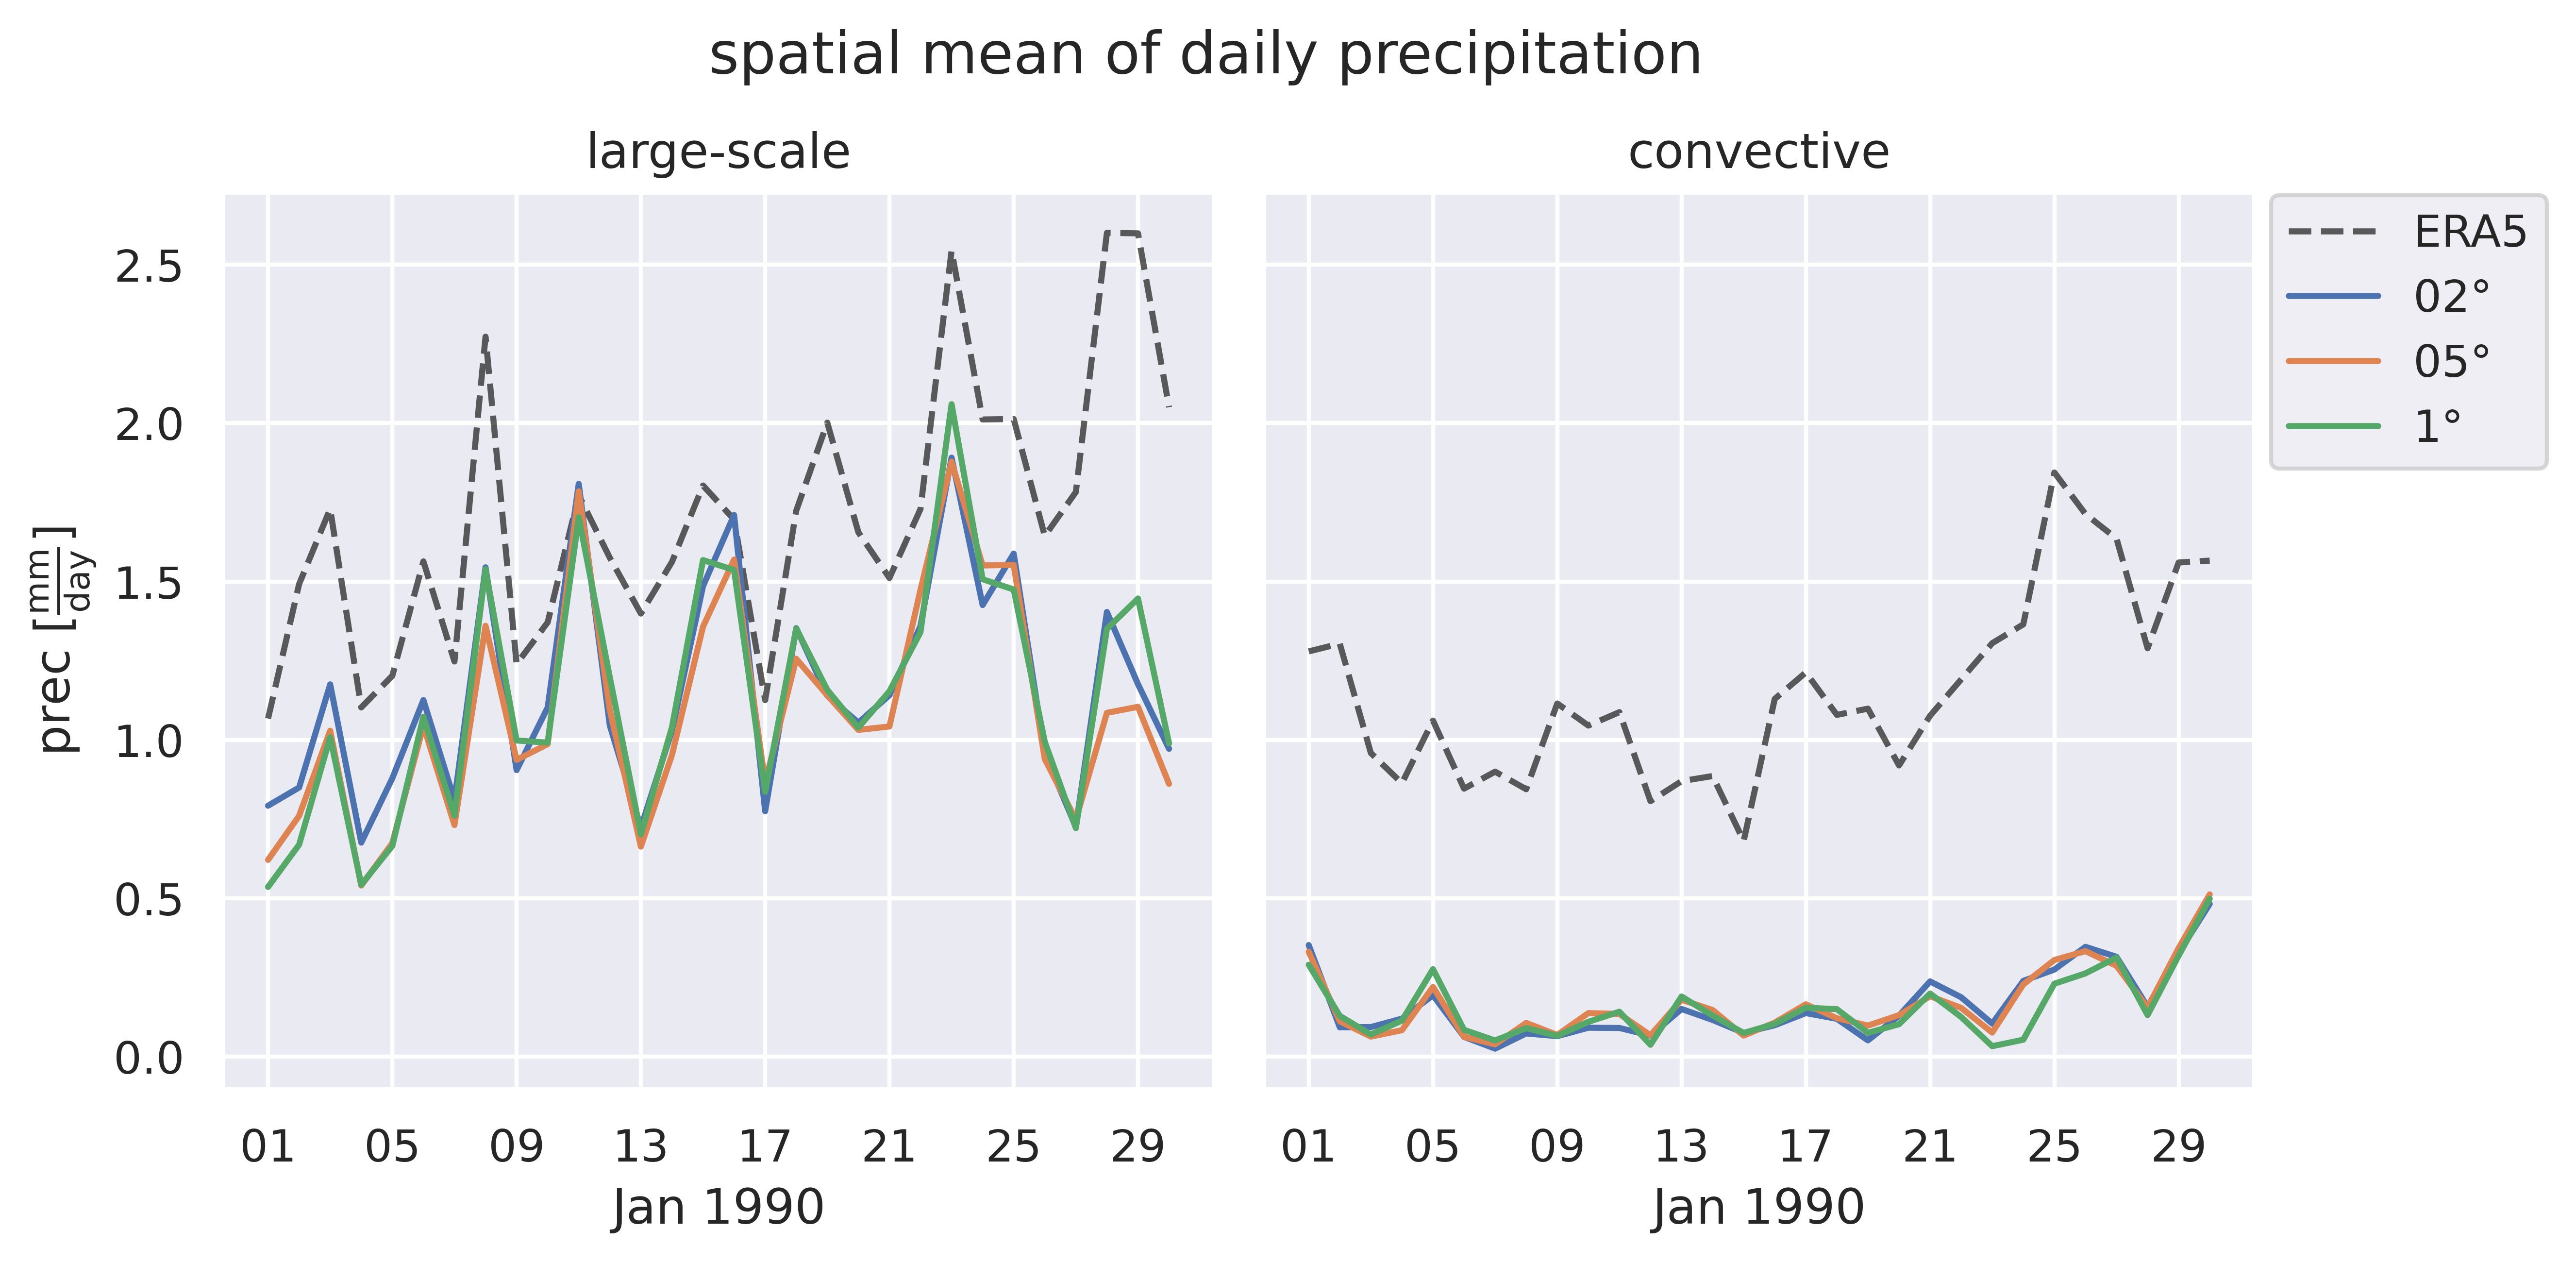

In [16]:
# plotting
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(9,4), gridspec_kw=dict(wspace=0.05))

for i, (cosmo, rea, title) in enumerate(zip([gsp, con],
                                          [gsp_rea, con_rea],
                                          ["large-scale", "convective"])):
    
    axs[i].plot(time_rea, rea, label="ERA5" if i == 0 else "_nolegend_",
                c="k", ls="--", alpha=0.7)
    for r in res:
        axs[i].plot(time, cosmo[r], label=f"{r}°" if i == 0 else "_nolegend_")
    
    axs[i].set_title(title)
    axs[i].xaxis.set_major_formatter(mdates.DateFormatter("%d"))
    axs[i].set_xlabel("Jan 1990")
    
axs[0].set_ylabel(r"prec [$\frac{\mathrm{mm}}{\mathrm{day}}$]")
fig.suptitle("spatial mean of daily precipitation", y=1.02)    
fig.legend(bbox_to_anchor=[1.02, 0.76], loc="right")
fig.savefig("../report/figs/5-gsp-con.png")

- alle Gitterauflösungen können konvektiven Niederschlag nicht darstellen, da in allen Simulationen parametrisiert
- die Unterschiede zwischen ERA5 und den Simulationen kommen hauptsächlich aus dem konvektiven Niederschlag, wohingegen
- der Unterschied innerhalb der Simulationen vom large-scale Niederschlag kommt! Das könnte daran liegen, dass das Niederschlagsgebiet bei höherer Auflösung besser lokalisiert werden kann & daher tendeziell kleiner ist

### Individual precipitation event

Und zwar der 27.-29. Januar, da sich dort die Niederschlagsmenge zwischen den einzelnen Simulationen unterscheidet & es keinen Einfluss der Anfangsbedingungen mehr gibt.

In [17]:
"""
# import data
lon = {}
lat = {}
gsp = {}
con = {}

for r in res:
    # large-scale
    f = Dataset(f"../output/gsp_totprec_{r}deg.nc")
    lon[r] = f.variables["lon"][:]
    lat[r] = f.variables["lat"][:]
    time = convTime(f.variables["time"][27:30])
    gsp[r] = f.variables["gsp"][27:30,:,:]
    f.close()
    # convective
    f = Dataset(f"../output/con_totprec_{r}deg.nc")
    con[r] = f.variables["con"][27:30,:,:]
    f.close()
"""
print("use total precipitation instead")

use total precipitation instead


In [18]:
# import total precipitation (grid-scale & convective)
lon = {}
lat = {}
totprec = {}

for r in res:
    f = Dataset(f"../output/totprec_{r}deg.nc")
    lon[r] = f.variables["lon"][:]
    lat[r] = f.variables["lat"][:]
    time = convTime(f.variables["time"][27:30])
    totprec[r] = f.variables["tot_prec"][27:30,:,:]
    f.close()

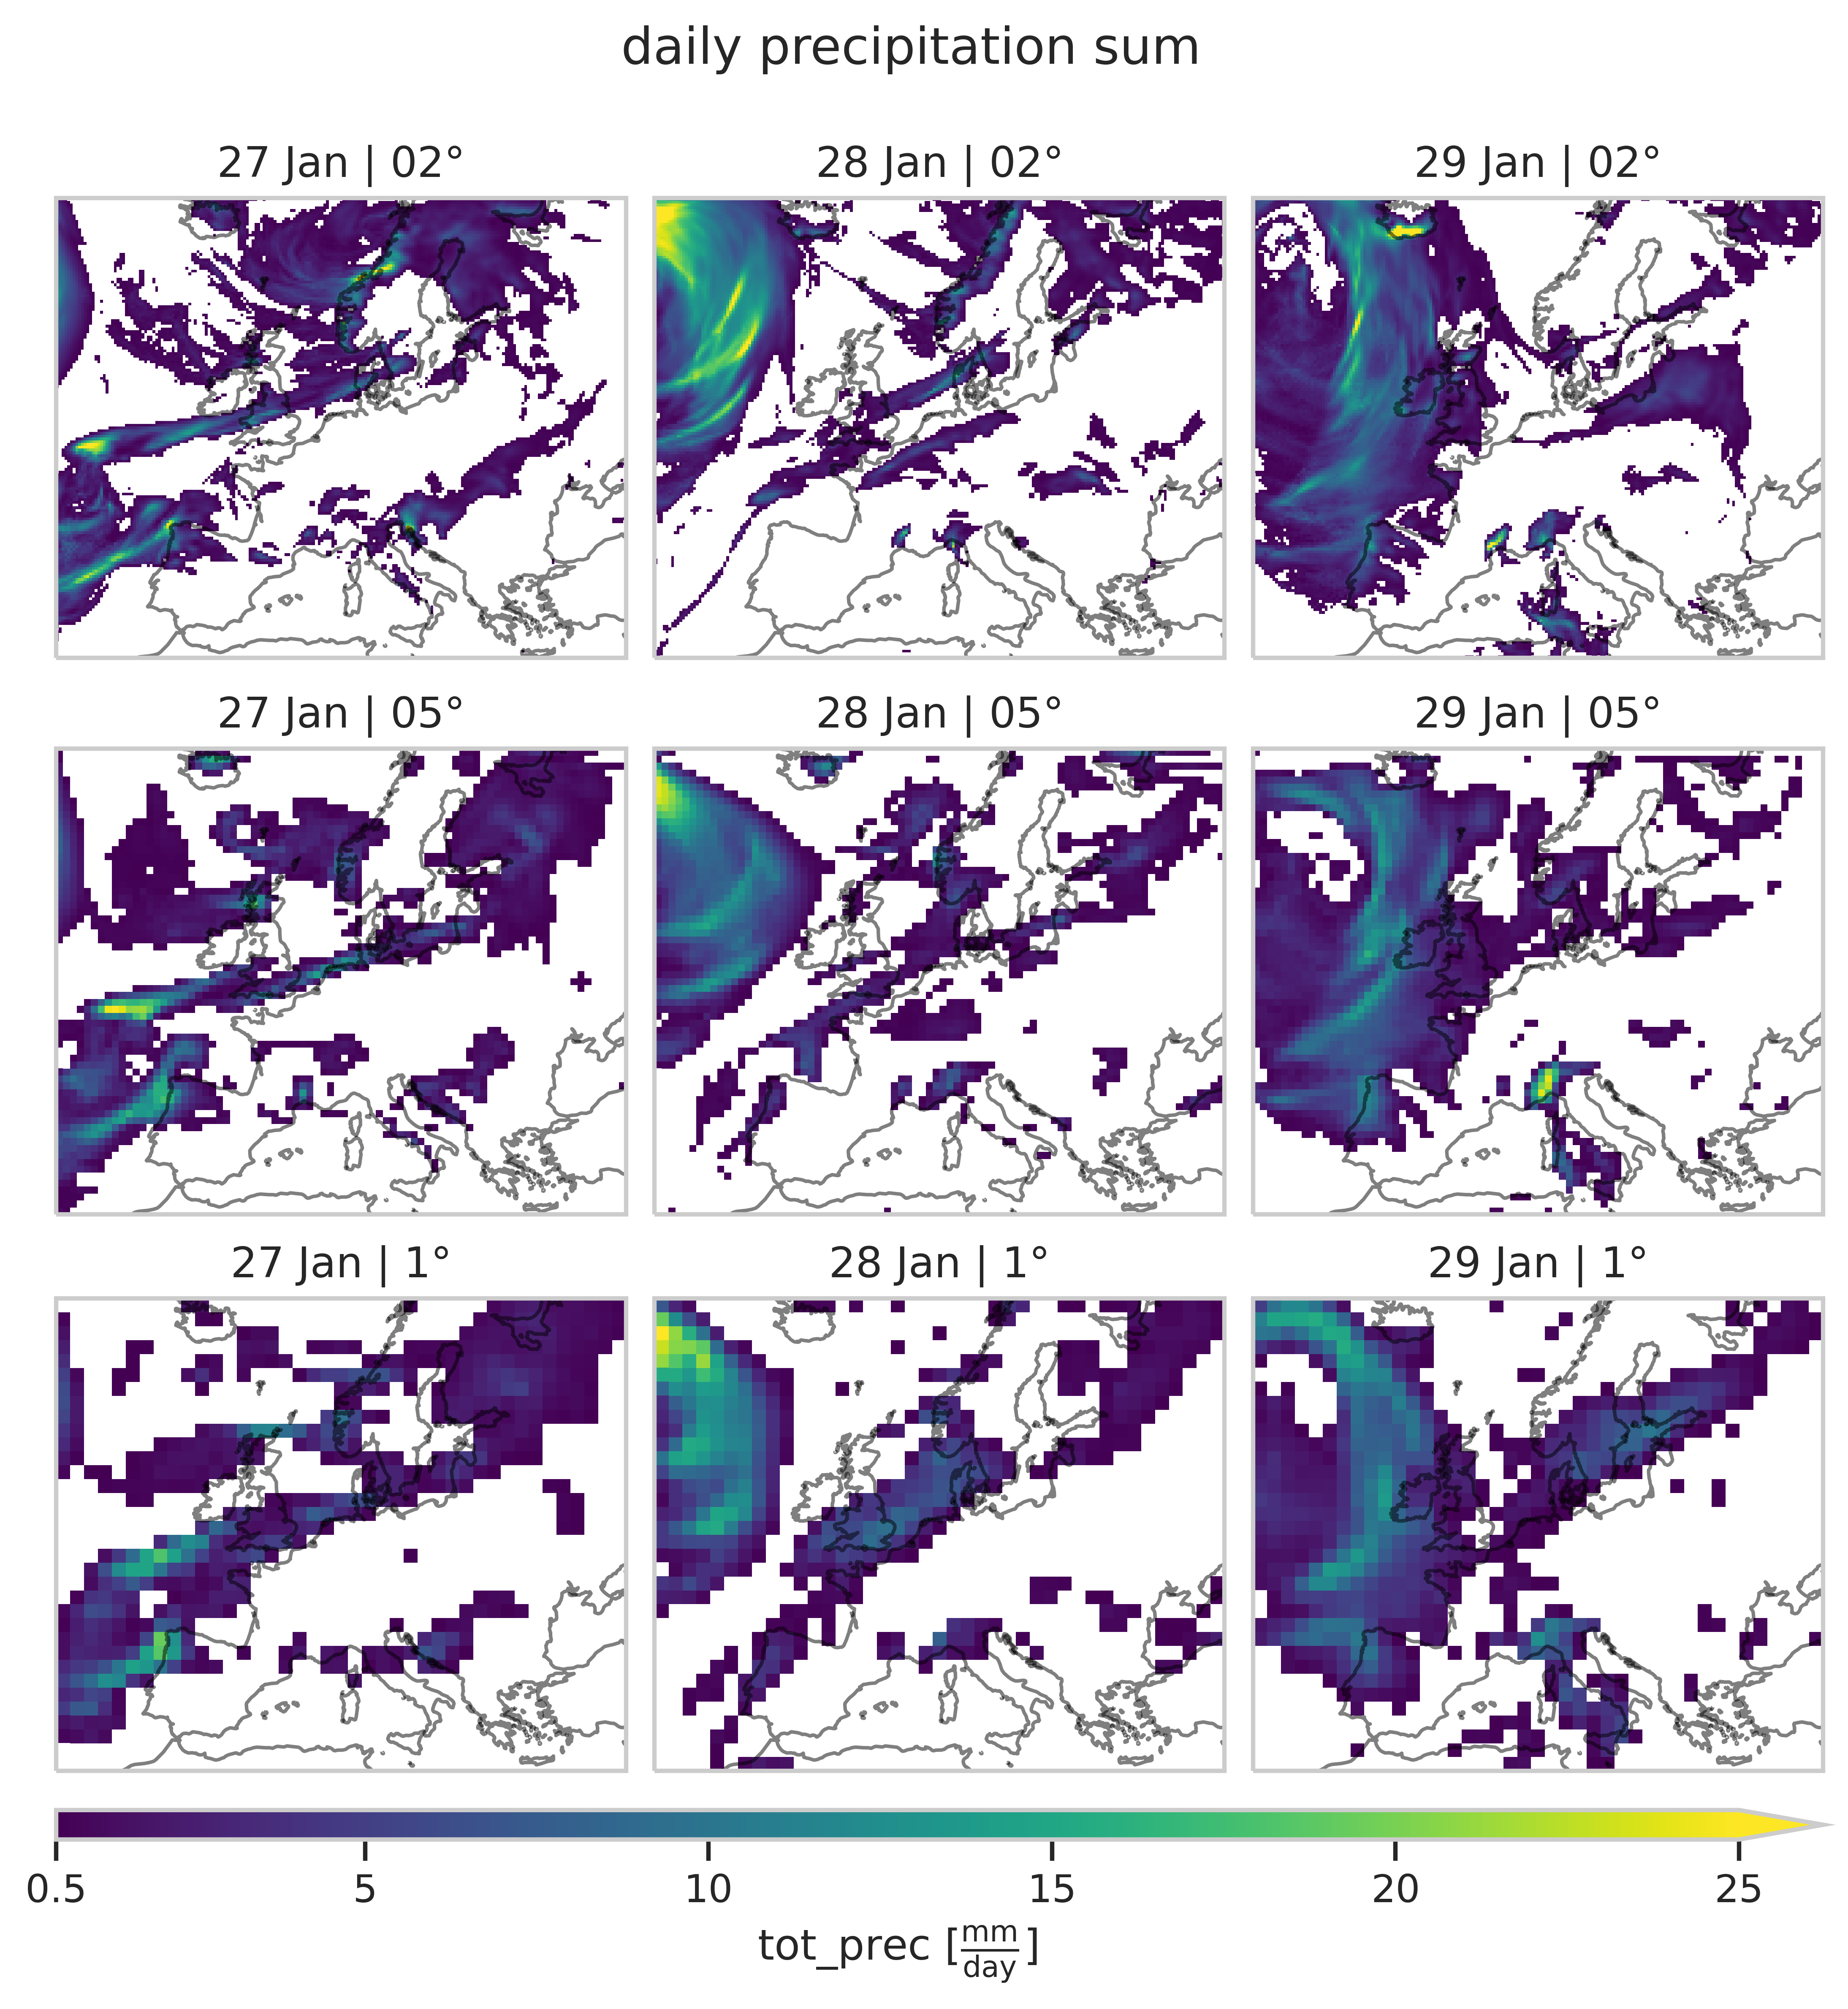

In [19]:
# adjust colormap
cmap = mpl.cm.get_cmap("viridis").copy()
cmap.set_under("w")

# tick locations and labels for colorbar
cticks = [0.5, 5, 10, 15, 20, 25]
clabels = ["0.5", "5", "10", "15", "20", "25"]

# plotting
with sns.axes_style("whitegrid"):
    fig, axs = plt.subplots(3, 3, figsize=(9,10), gridspec_kw=dict(wspace=0.05, hspace=0.1),
                            subplot_kw=dict(projection = proj))

    for i, r in enumerate(res):
        for tt in range(3):
            cm = axs[i, tt].pcolormesh(lon[r], lat[r], totprec[r][tt,:,:], transform=trans, shading="nearest", cmap=cmap, vmin=0.5, vmax=25)
            axs[i, tt].coastlines(alpha=0.5)
            axs[i, tt].set_title(f"{time[tt].strftime('%d %b')} | {r}°")
            #cb = fig.colorbar(cm, orientation="horizontal", extend="max", ax=axs[i, tt])

    cb = fig.colorbar(cm, orientation="horizontal", extend="max", ticks=cticks,
                      pad=0.02, aspect=60, ax=axs.flatten())
    cb.set_ticklabels(clabels)
    cb.set_label(r"tot_prec [$\frac{\mathrm{mm}}{\mathrm{day}}$]")    
    fig.suptitle("daily precipitation sum", y=0.93)
    fig.savefig("../report/figs/6-event.png")